### RNN for image classification

Since images are 2D, we can simply pretend an image is a time series.

In [1]:
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as pt
from datetime import datetime

train_dataset = torchvision.datasets.MNIST(root='.', train=True, transform= transforms.ToTensor(), download=True)
test_dataset = torchvision.datasets.MNIST(root='.', train=False, transform= transforms.ToTensor(), download=True)

batch_size = 128

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [2]:
class RNN(nn.Module):
    def __init__(self, n_inputs, n_hidden, n_rnnlayers, n_outputs):
        super(RNN, self).__init__()
        self.D = n_inputs
        self.M = n_hidden 
        self.K = n_outputs
        self.L = n_rnnlayers
        self.rnn = nn.LSTM(
            input_size = self.D,
            hidden_size= self.M,
            num_layers = self.L,
            batch_first = True)
        self.fc = nn.Linear(self.M, self.K)
    def forward(self, X):
        h0 = torch.zeros(self.L, X.size(0), self.M).to(device)
        c0 = torch.zeros(self.L, X.size(0), self.M).to(device)

        out, _ = self.rnn(X, (h0,c0))
        out = self.fc(out[:, -1, :])
        return out

In [3]:
model= RNN(28,128,2,10)

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

cuda:0


RNN(
  (rnn): LSTM(28, 128, num_layers=2, batch_first=True)
  (fc): Linear(in_features=128, out_features=10, bias=True)
)

In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [6]:
n_epochs = 10
train_losses = np.zeros(n_epochs)
test_losses = np.zeros(n_epochs)
for it in range(n_epochs):
    train_loss = []
    for inputs,targets in train_loader:
      inputs, targets = inputs.to(device), targets.to(device)
      inputs = inputs.view(-1, 28, 28)
      optimizer.zero_grad()
      outputs = model(inputs)
      loss = criterion(outputs, targets)
      loss.backward()
      optimizer.step()
      train_loss.append(loss.item())
    train_loss = np.mean(train_loss)
    
    test_loss = []
    for inputs,targets in test_loader:
      inputs, targets = inputs.to(device), targets.to(device)
      inputs = inputs.view(-1, 28, 28)
      outputs = model(inputs)
      loss = criterion(outputs, targets)
      test_loss.append(loss.item())
    test_loss = np.mean(test_loss)
    
    train_losses[it] = train_loss
    test_losses[it] = test_loss
    
    
    print(f'Epoch {it+1}/{n_epochs}, Train Loss {train_loss:.4f}, Test Loss {test_loss:.4f}')

Epoch 1/10, Train Loss 0.5855, Test Loss 0.1899
Epoch 2/10, Train Loss 0.1336, Test Loss 0.1001
Epoch 3/10, Train Loss 0.0819, Test Loss 0.0728
Epoch 4/10, Train Loss 0.0619, Test Loss 0.0599
Epoch 5/10, Train Loss 0.0481, Test Loss 0.0620
Epoch 6/10, Train Loss 0.0426, Test Loss 0.0516
Epoch 7/10, Train Loss 0.0374, Test Loss 0.0420
Epoch 8/10, Train Loss 0.0310, Test Loss 0.0423
Epoch 9/10, Train Loss 0.0290, Test Loss 0.0493
Epoch 10/10, Train Loss 0.0247, Test Loss 0.0446


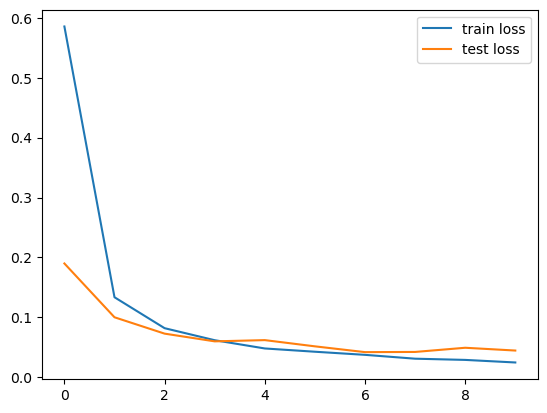

In [7]:
import matplotlib.pyplot as plt
plt.plot(train_losses, label = "train loss")
plt.plot(test_losses, label = "test loss")
plt.legend()
plt.show()